In [14]:
import pandas as pd
import numpy as np
import psutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from sklearn.model_selection import cross_val_score
import optuna
import pickle
import matplotlib.pyplot as plt
import optuna.visualization as vis
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef, accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score

# Functions

In [2]:
def visualize_CM(matrix):
    """
    Visualize Correlation Matrix
    """
    sns.heatmap(matrix,annot=True)

# Load Data

In [3]:
data = pd.read_csv('data/CIC_IoT2023/custom/multiclass_classification_data_1000.csv')

In [4]:
data = data.drop(['Unnamed: 0', 'label'], axis=1)

In [5]:
data

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
0,0.000000,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
1,0.000000,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
2,0.000000,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
3,0.000000,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
4,0.000000,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,1.245453,84831.8,6.00,62.30,59.269257,59.269257,0.0,0.0,0.0,0.0,...,529.760119,623.20,1.879692e-03,5.5,44.798738,749.193946,352519.133101,0.80,38.50,Bruteforce
7996,1.549077,1116.1,7.10,82.00,184.752583,184.752583,0.0,0.0,0.0,0.0,...,472.746293,214.90,1.666013e+08,13.5,26.110301,670.027076,225374.808644,1.00,244.60,Bruteforce
7997,1928.654402,69985.6,9.80,89.00,0.444028,0.444028,0.0,0.0,0.0,0.0,...,53.597589,108.20,2.198360e-02,5.5,13.710583,75.798437,3803.107186,0.80,38.50,Bruteforce
7998,7.056125,1005.2,6.00,62.20,6.904529,6.904529,0.0,0.0,0.0,0.0,...,83.988279,130.80,1.156039e-02,5.5,16.163288,118.777363,8923.574843,0.90,38.50,Bruteforce


# Prepare Data

In [6]:
X = data.drop(['Attack Type'], axis = 1)
y = data['Attack Type']

In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [8]:
le = LabelEncoder()

y = le.fit_transform(y)

In [9]:
attack_dict = {}
data['Attack Number'] = le.fit_transform(data['Attack Type'])
encoded_values = data['Attack Number'].unique()
for val in sorted(encoded_values):
    attack_dict[val] = le.inverse_transform([val])[0]
    print(f"{val}: {le.inverse_transform([val])[0]}")

0: Benign
1: Bruteforce
2: DDoS
3: DoS
4: Mirai
5: Recon
6: Spoofing
7: Web


# Multiclass classification

Measure classification performance separately on every attack type

In [10]:
results_dict = {}

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6800, 46), (6800,), (1200, 46), (1200,))

In [12]:
unique, counts = np.unique(y_train, return_counts=True)
for x, y in zip(unique, counts):
    print(f"{x}: {y}")

0: 852
1: 832
2: 874
3: 833
4: 853
5: 852
6: 863
7: 841


In [13]:
unique, counts = np.unique(y_test, return_counts=True)
for x, y in zip(unique, counts):
    print(f"{x}: {y}")

0: 148
1: 168
2: 126
3: 167
4: 147
5: 148
6: 137
7: 159


In [34]:
%%time

start = time.time()

process = psutil.Process()
cpu_before = process.cpu_percent(interval=None)
mem_before = process.memory_info().rss

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

cpu_after = process.cpu_percent(interval=None)
mem_after = process.memory_info().rss

y_pred = xgb_clf.predict(X_test)

end = time.time()

XGB_Time = end - start

CPU times: user 26.8 s, sys: 59.5 ms, total: 26.8 s
Wall time: 4.04 s


In [35]:
xgb_clf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

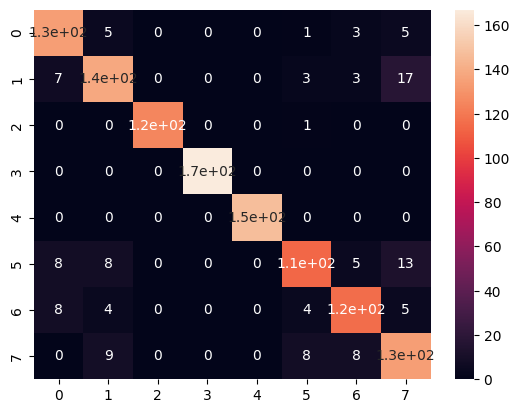

In [36]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [37]:
%%time

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

latencies = []
for sample in X_test:
    start_time = time.perf_counter()  # Higher precision than time.time()
    _ = xgb_clf.predict(sample.reshape(1, -1))  # Reshape for single sample
    latencies.append(time.perf_counter() - start_time)
mean_latency = np.mean(latencies) * 1000
std_latency = np.std(latencies) * 1000

CPU times: user 13.4 s, sys: 55.6 ms, total: 13.4 s
Wall time: 2.01 s


In [38]:
print(f"CPU usage: {cpu_after - cpu_before}%")
memory = (mem_after - mem_before) / (1024 * 1024)
print(f"Memory usage: {(mem_after - mem_before) / (1024 * 1024)} MB")
print(f"Memory usage: {(mem_after - mem_before) / (1024)} KB")
print(f"Memory usage: {(mem_after - mem_before)} B")
print(f"Prediction time: {end - start} seconds")

CPU usage: 663.4%
Memory usage: 4.703125 MB
Memory usage: 4816.0 KB
Memory usage: 4931584 B
Prediction time: 4.041463136672974 seconds


In [39]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, mean_latency, std_latency, memory, XGB_Time]
results_dict["XGBoost"] = results

In [40]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Mean Latency (ms)", "Standard Latency (ms)", "Memory Usage (MB)", "Time"])

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Mean Latency (ms),Standard Latency (ms),Memory Usage (MB),Time
XGBoost,0.895833,0.897204,0.895808,0.895833,0.881018,0.383333,1.900000,1.378405,1.660697,3.038340,4.703125,4.041463
XGBoost_best,0.895000,0.898026,0.895002,0.895000,0.880274,0.391667,1.961667,1.400595,2.148740,4.203225,121.625000,2.310155


# Hyperparameter tuning

In [93]:
# Defining the objective function
def objective(trial):
    param = {
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10, log=True),
    }
    
    # initializing the XGBoost model
    model = xgb.XGBClassifier(**param,
                              objective = "multi:softmax",
                              num_class = 8,
                              tree_method = 'hist',  # Using GPU for training 
                              device =  'cuda')       # If you have multiple GPUs, you can specify the GPU ID
                              
    # if you try in the computer without GPU, just remove the last 2 params (tree_method & device)
    
    score = cross_val_score(model, X_train, y_train, cv=3).mean()   # calculating score using cross-validation
    return score

In [ ]:
%%time

# Create and run the optimization process with 100 trials
study = optuna.create_study(study_name="example_xgboost_study", direction='maximize') 
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=-1)   

# Retrieve the best parameter values
best_params = study.best_params
print(f"\nBest parameters: {best_params}")

[I 2025-04-07 15:06:25,681] A new study created in memory with name: example_xgboost_study


  0%|          | 0/100 [00:00<?, ?it/s]

[15:06:55] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



[I 2025-04-07 15:07:59,144] Trial 0 finished with value: 0.886212052906937 and parameters: {'booster': 'gbtree', 'max_depth': 3, 'learning_rate': 0.04425460818598997, 'n_estimators': 228, 'subsample': 0.8663660928983121, 'colsample_bytree': 0.6295113589545083, 'min_child_weight': 3, 'gamma': 0.19775014886172768, 'reg_alpha': 0.08952125792231558, 'reg_lambda': 0.9254052286757156}. Best is trial 0 with value: 0.886212052906937.
[I 2025-04-07 15:08:26,094] Trial 5 finished with value: 0.9043504309064082 and parameters: {'booster': 'gbtree', 'max_depth': 7, 'learning_rate': 0.03414631141982154, 'n_estimators': 208, 'subsample': 0.6781251617100128, 'colsample_bytree': 0.5260465330454768, 'min_child_weight': 2, 'gamma': 0.014465168137021176, 'reg_alpha': 0.0003581522991396717, 'reg_lambda': 1.253023865249292}. Best is trial 5 with value: 0.9043504309064082.
[I 2025-04-07 15:08:47,717] Trial 2 finished with value: 0.9021304154999886 and parameters: {'booster': 'gbtree', 'max_depth': 10, 'lear

In [ ]:
display(vis.plot_param_importances(study))
display(vis.plot_optimization_history(study))

In [25]:
best_params = {
    'booster': 'gbtree',
    'max_depth': 9,
    'learning_rate': 0.08183589453975319,
    'n_estimators': 1000,
    'subsample': 0.9186370615068721,
    'colsample_bytree': 0.8481467570313783,
    'min_child_weight': 6,
    'gamma': 0.9146148361655273,
    'reg_alpha': 1.6884365188339305e-05,
    'reg_lambda': 0.09860216667224188
}

In [26]:
%%time

start = time.time()

# Train the model with the best parameters
best_model = xgb.XGBClassifier(**best_params,
                               objective = "multi:softmax",
                               num_class = 8,
                               tree_method = 'hist',  # Using GPU for training 
                               device =  'cuda'
                              )

process = psutil.Process()
cpu_before = process.cpu_percent(interval=None)
mem_before = process.memory_info().rss

best_model.fit(X_train, y_train)

cpu_after = process.cpu_percent(interval=None)
mem_after = process.memory_info().rss

# Predict the test data
y_pred = best_model.predict(X_test)

end = time.time()

XGB_upd_Time = end - start

CPU times: user 5.84 s, sys: 80.8 ms, total: 5.92 s
Wall time: 5.19 s


/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [17:52:38] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


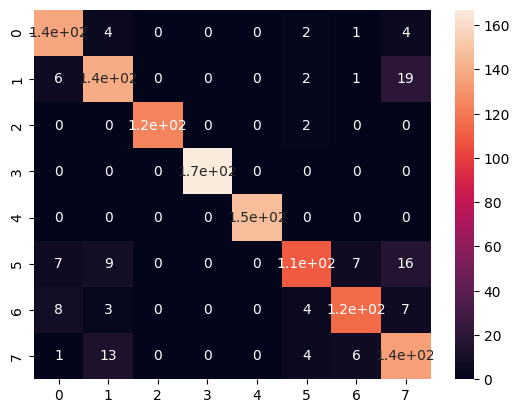

In [27]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [28]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

latencies = []
for sample in X_test:
    start_time = time.perf_counter()  # Higher precision than time.time()
    _ = xgb_clf.predict(sample.reshape(1, -1))  # Reshape for single sample
    latencies.append(time.perf_counter() - start_time)
mean_latency = np.mean(latencies) * 1000
std_latency = np.std(latencies) * 1000

In [29]:
print(f"CPU usage: {cpu_after - cpu_before}%")
memory = (mem_after - mem_before) / (1024 * 1024)
print(f"Memory usage: {(mem_after - mem_before) / (1024 * 1024)} MB")
print(f"Memory usage: {(mem_after - mem_before) / (1024)} KB")
print(f"Memory usage: {(mem_after - mem_before)} B")
print(f"Prediction time: {end - start} seconds")

CPU usage: 113.1%
Memory usage: 121.625 MB
Memory usage: 124544.0 KB
Memory usage: 127533056 B
Prediction time: 5.18537163734436 seconds


In [32]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, mean_latency, std_latency, memory, XGB_Time]
results_dict["XGBoost_best"] = results

In [33]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Mean Latency (ms)", "Standard Latency (ms)", "Memory Usage (MB)", "Time"])

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Mean Latency (ms),Standard Latency (ms),Memory Usage (MB),Time
XGBoost,0.895,0.898026,0.895002,0.895,0.880274,0.391667,1.961667,1.400595,2.14874,4.203225,121.625,2.310155
XGBoost_best,0.895,0.898026,0.895002,0.895,0.880274,0.391667,1.961667,1.400595,2.14874,4.203225,121.625,2.310155


# Visualize results

In [130]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [131]:
def result_plot(_dict, name, folder):
    attacks = {}
    higher = ["F1", "Accuracy", "Precision", "Recall", "MCC", "precision", "recall", "f1-score", "support"]
    fig, ax = plt.subplots(figsize=(10,10))
    if name in higher:
        tmp = sorted(_dict.items(), key = lambda x:x[1])
    else:
        tmp = sorted(_dict.items(), key = lambda x:x[1], reverse=True)
    for x in tmp:
        attacks[x[0]] = x[1]
    ax.bar(attacks.keys(), attacks.values())
    rects = ax.patches
    results = [i for i in attacks.values()]
    labels = [f"{results[i]:.6f}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
        )
    if name in higher:
        name = name.capitalize()
        ax.set_title(f'{name} (higher is better)', fontsize=16, fontweight="bold")
    else:
        ax.set_title(f'{name} (lower is better)', fontsize=16, fontweight="bold")
    ax.set_xlabel(f'{name}')
    ax.set_ylabel('Score')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    plt.savefig(f"images/results/{folder}/{name}.png")

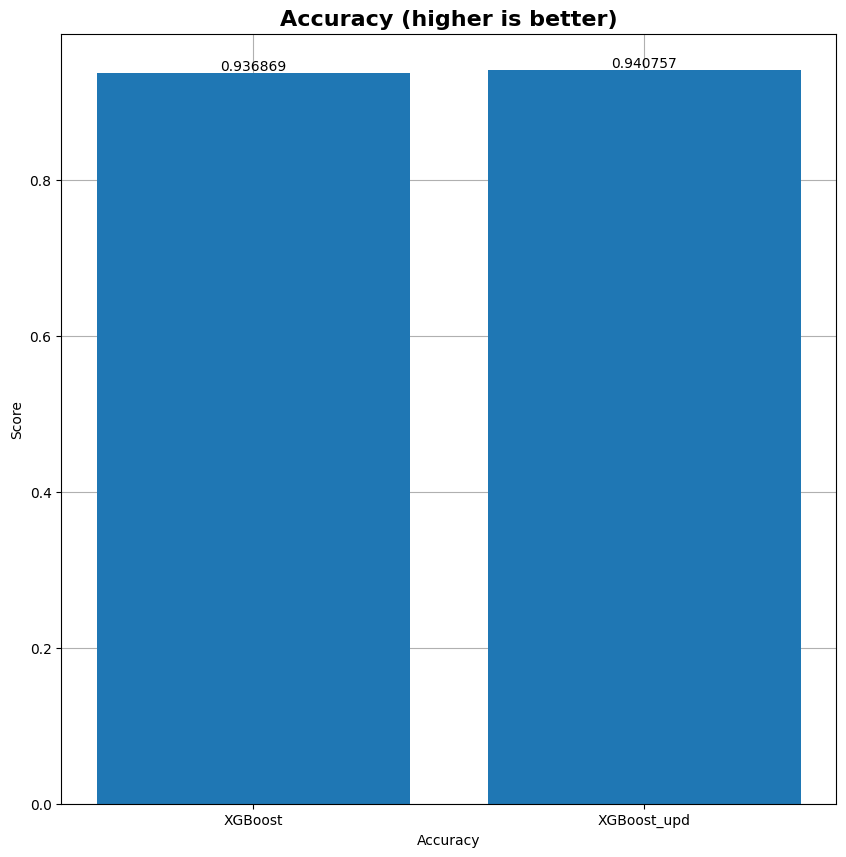

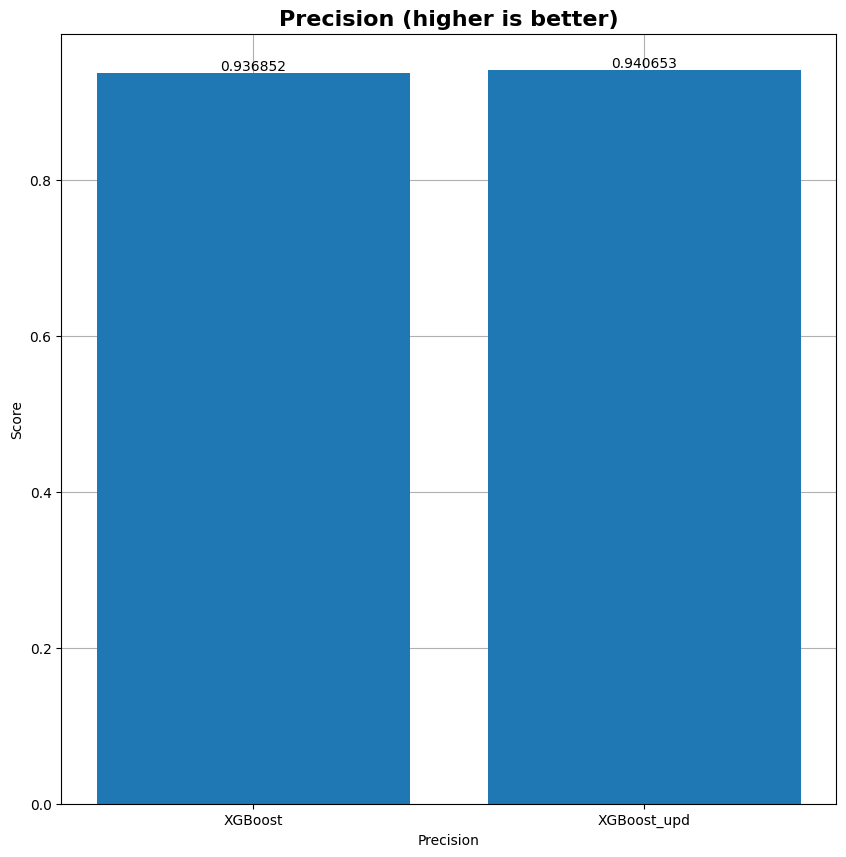

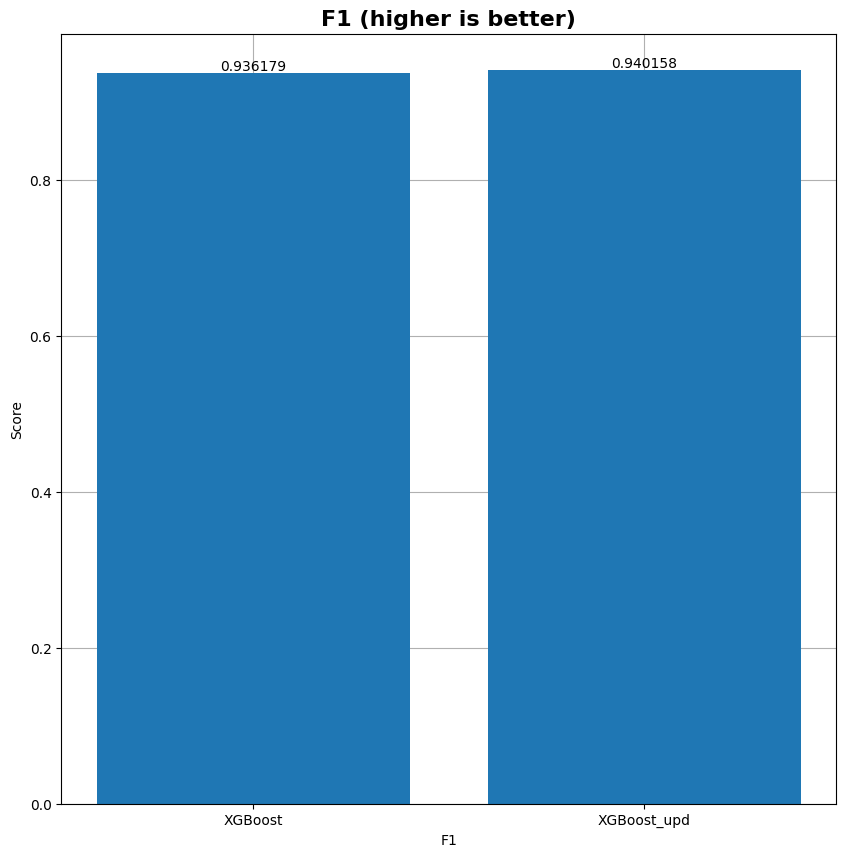

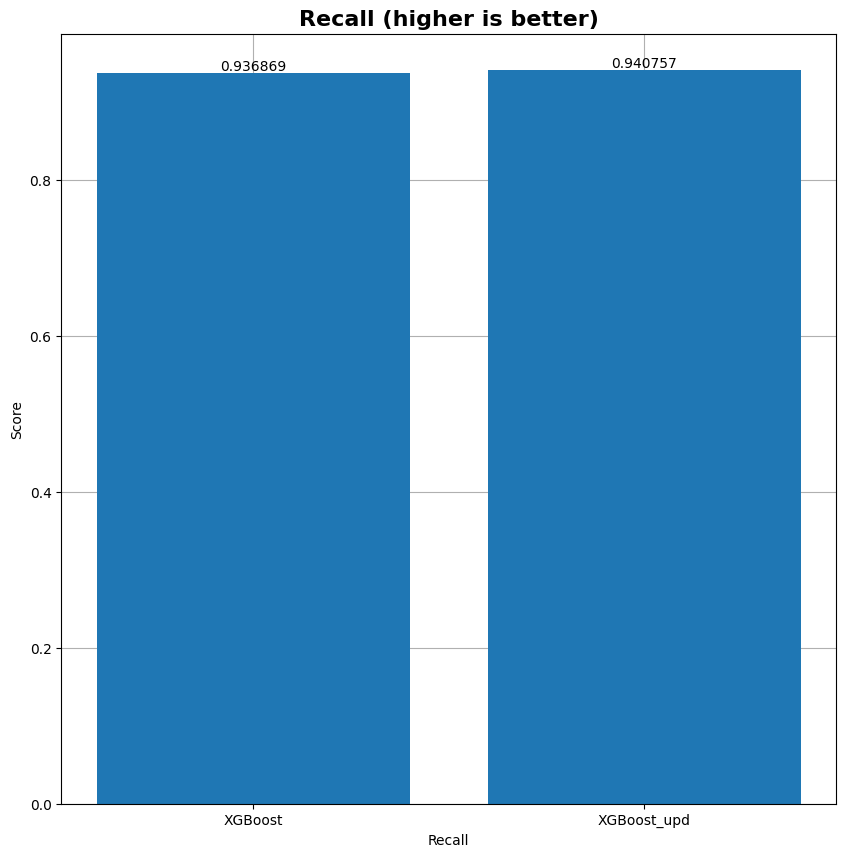

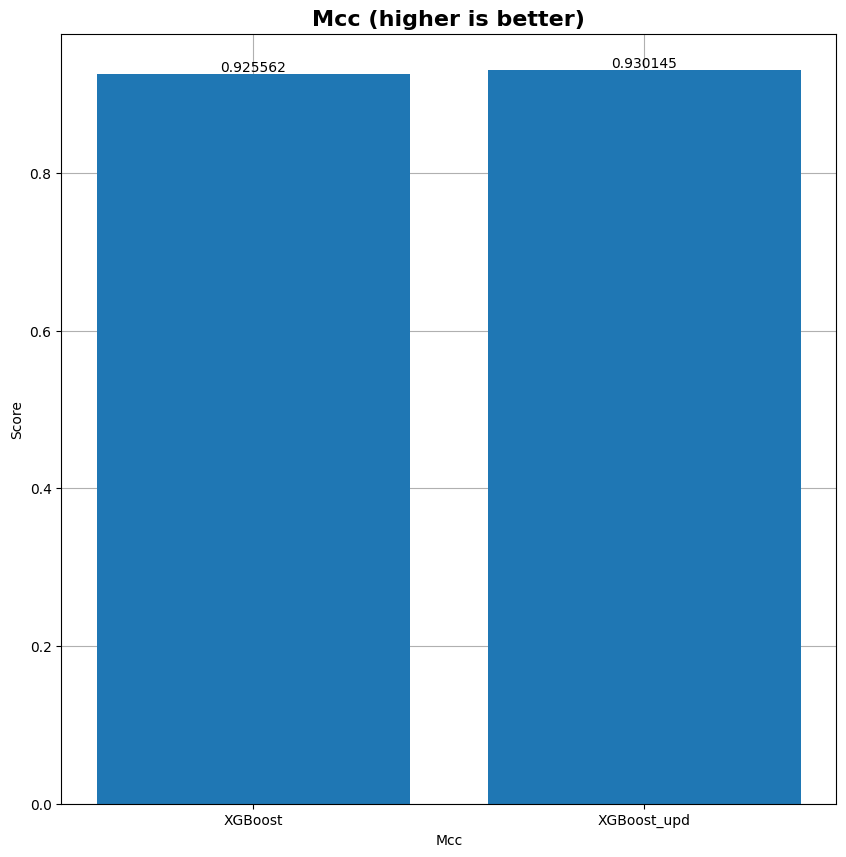

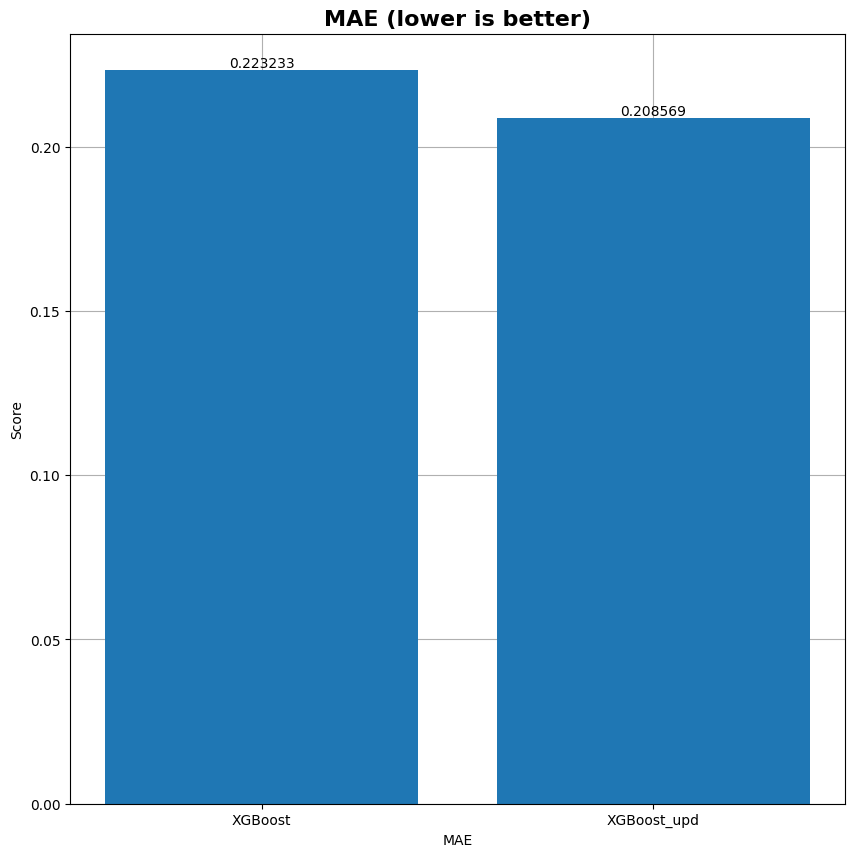

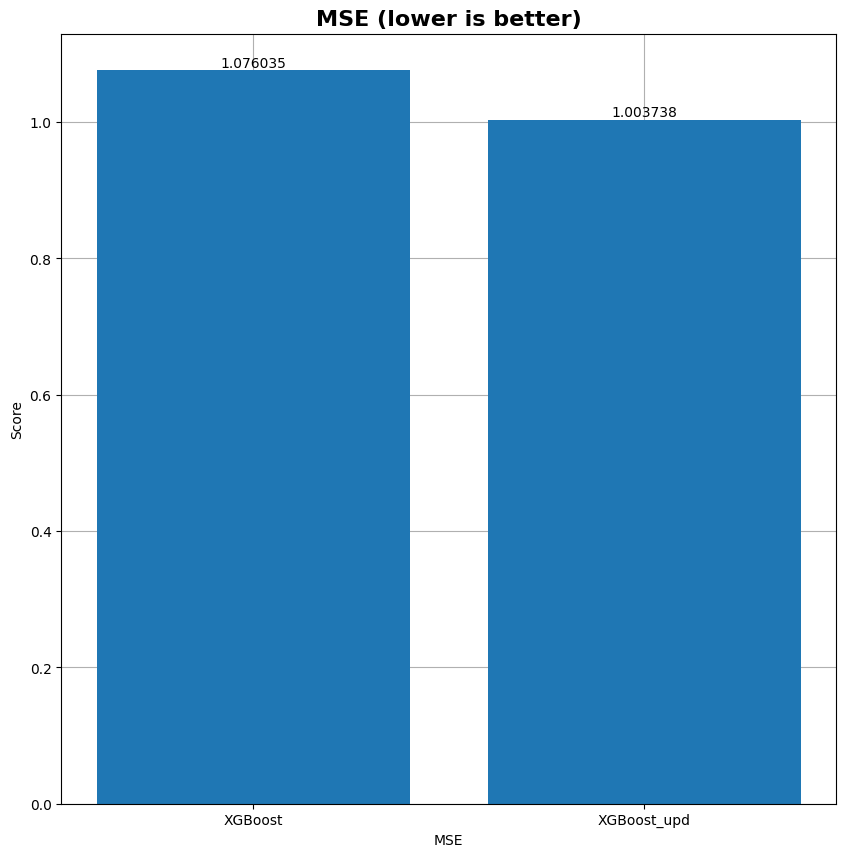

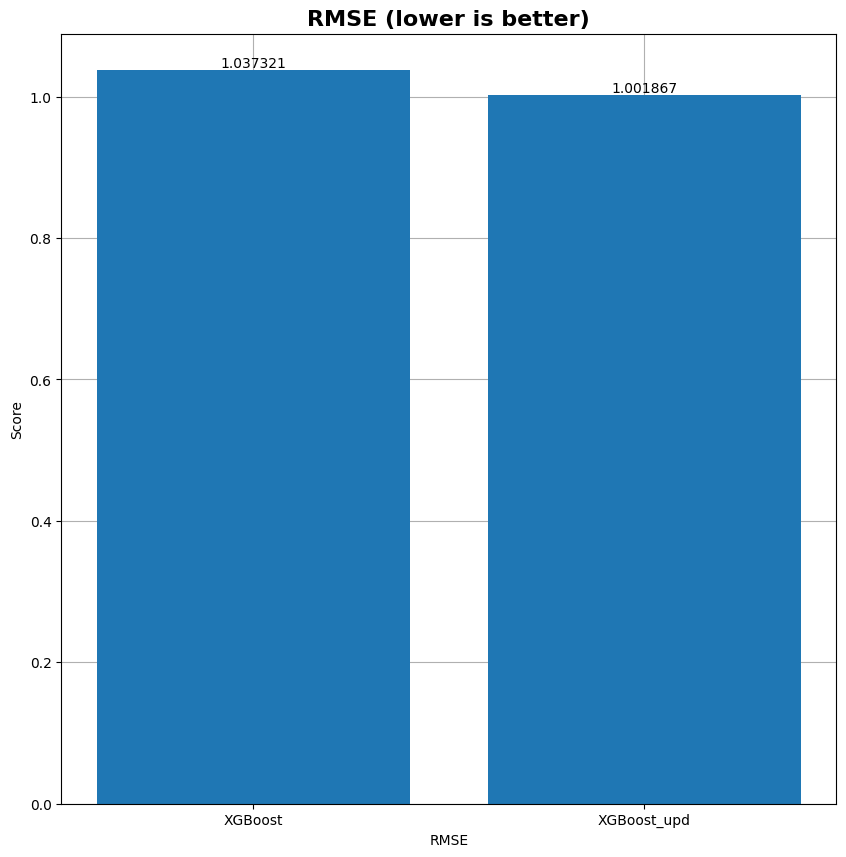

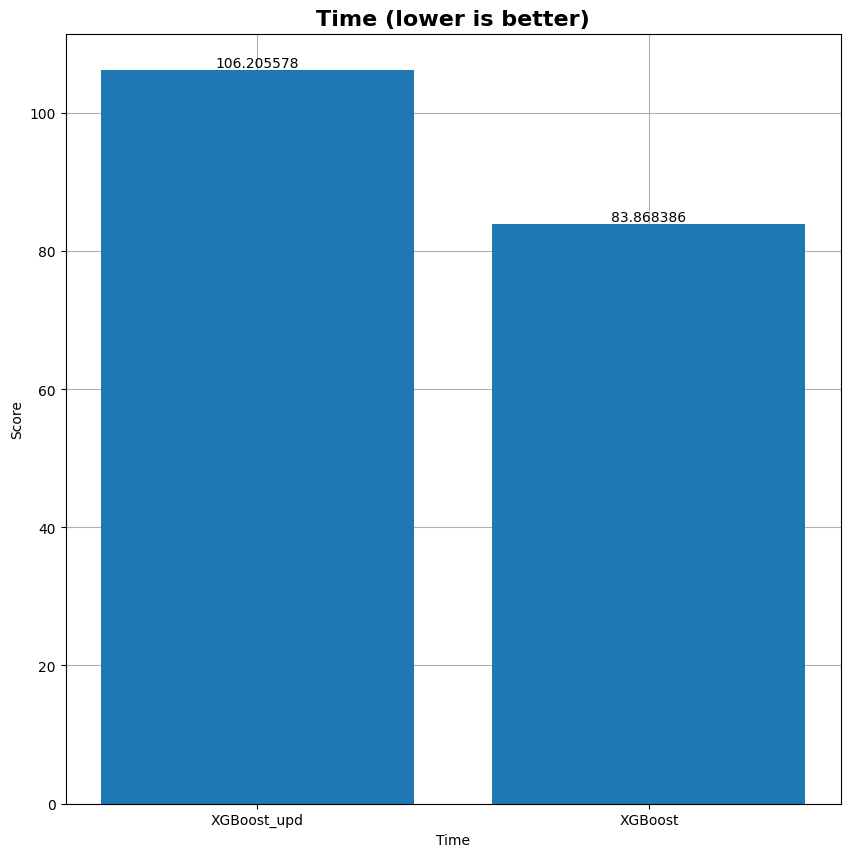

In [132]:
for name in results_df:
    _dict = {}
    for keys, values in zip(range(len(results_df[name].keys())), results_df[name]):
        _dict[results_df[name].keys()[keys]] = values
    result_plot(_dict, name, "XGBoost_HP_Tune")

In [133]:
cr = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(cr).transpose()

In [134]:
df

,precision,recall,f1-score,support
0,0.890595,0.938309,0.913829,17993.000000
1,0.910950,0.684341,0.781551,2018.000000
2,0.999611,0.999444,0.999528,17999.000000
3,0.999666,0.999611,0.999639,17990.000000
4,1.000000,0.999889,0.999944,18011.000000
5,0.878145,0.901461,0.889650,18003.000000
6,0.904754,0.881414,0.892932,17987.000000
7,0.815749,0.711648,0.760151,3683.000000
accuracy,0.940757,0.940757,0.940757,0.940757
macro avg,0.924934,0.889515,0.904653,113684.000000


In [135]:
cr.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', 'accuracy', 'macro avg', 'weighted avg'])

In [136]:
attack_dict

{np.int64(0): 'Benign',
 np.int64(1): 'Bruteforce',
 np.int64(2): 'DDoS',
 np.int64(3): 'DoS',
 np.int64(4): 'Mirai',
 np.int64(5): 'Recon',
 np.int64(6): 'Spoofing',
 np.int64(7): 'Web'}

In [137]:
mc_results = {}

for key, name in cr.items():
    if key not in ['accuracy', 'macro avg', 'weighted avg']:
        if int(key) in attack_dict:
            print(f"{key}, {attack_dict[int(key)]}, {cr[key]}")
            mc_results[attack_dict[int(key)]] = cr[key]

0, Benign, {'precision': 0.8905945033496862, 'recall': 0.938309342522092, 'f1-score': 0.9138294993234101, 'support': 17993.0}
1, Bruteforce, {'precision': 0.9109498680738787, 'recall': 0.6843409316154608, 'f1-score': 0.7815506508205999, 'support': 2018.0}
2, DDoS, {'precision': 0.9996110246721494, 'recall': 0.9994444135785321, 'f1-score': 0.9995277121822476, 'support': 17999.0}
3, DoS, {'precision': 0.9996664628384012, 'recall': 0.9996108949416342, 'f1-score': 0.999638678117791, 'support': 17990.0}
4, Mirai, {'precision': 1.0, 'recall': 0.9998889567486536, 'f1-score': 0.9999444752915048, 'support': 18011.0}
5, Recon, {'precision': 0.8781451220172068, 'recall': 0.9014608676331722, 'f1-score': 0.8896502576471879, 'support': 18003.0}
6, Spoofing, {'precision': 0.9047537522113793, 'recall': 0.8814143548118085, 'f1-score': 0.8929315685722332, 'support': 17987.0}
7, Web, {'precision': 0.8157485216308745, 'recall': 0.7116481129513983, 'f1-score': 0.7601508120649652, 'support': 3683.0}


In [138]:
mc_results = pd.DataFrame(mc_results).transpose()

In [139]:
mc_results

,precision,recall,f1-score,support
Benign,0.890595,0.938309,0.913829,17993.0
Bruteforce,0.910950,0.684341,0.781551,2018.0
DDoS,0.999611,0.999444,0.999528,17999.0
DoS,0.999666,0.999611,0.999639,17990.0
Mirai,1.000000,0.999889,0.999944,18011.0
Recon,0.878145,0.901461,0.889650,18003.0
Spoofing,0.904754,0.881414,0.892932,17987.0
Web,0.815749,0.711648,0.760151,3683.0


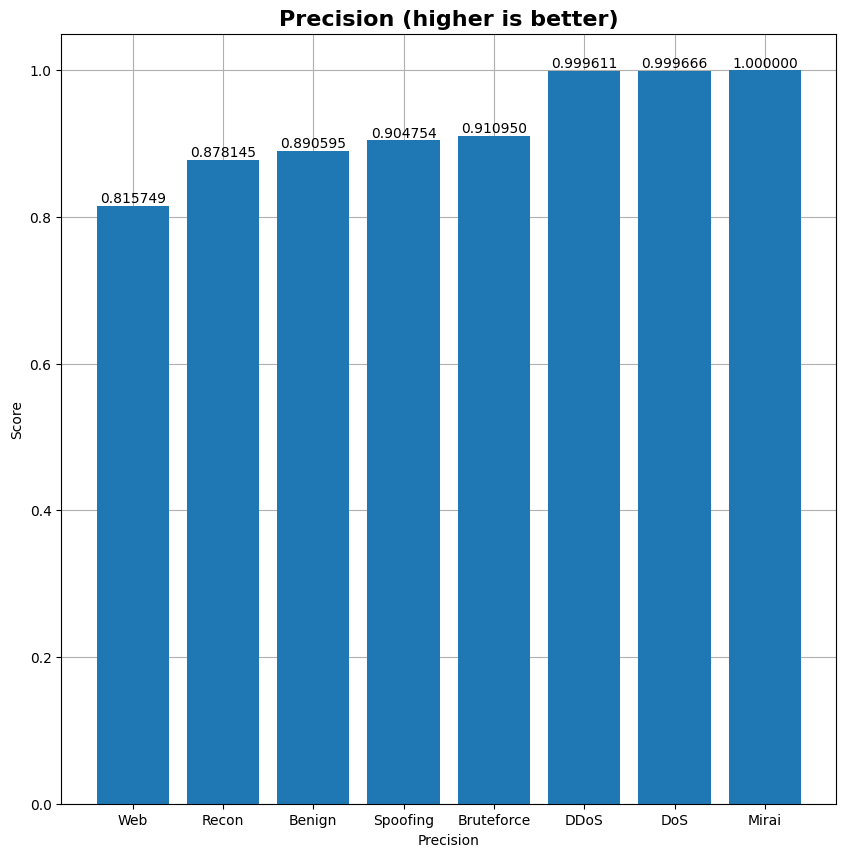

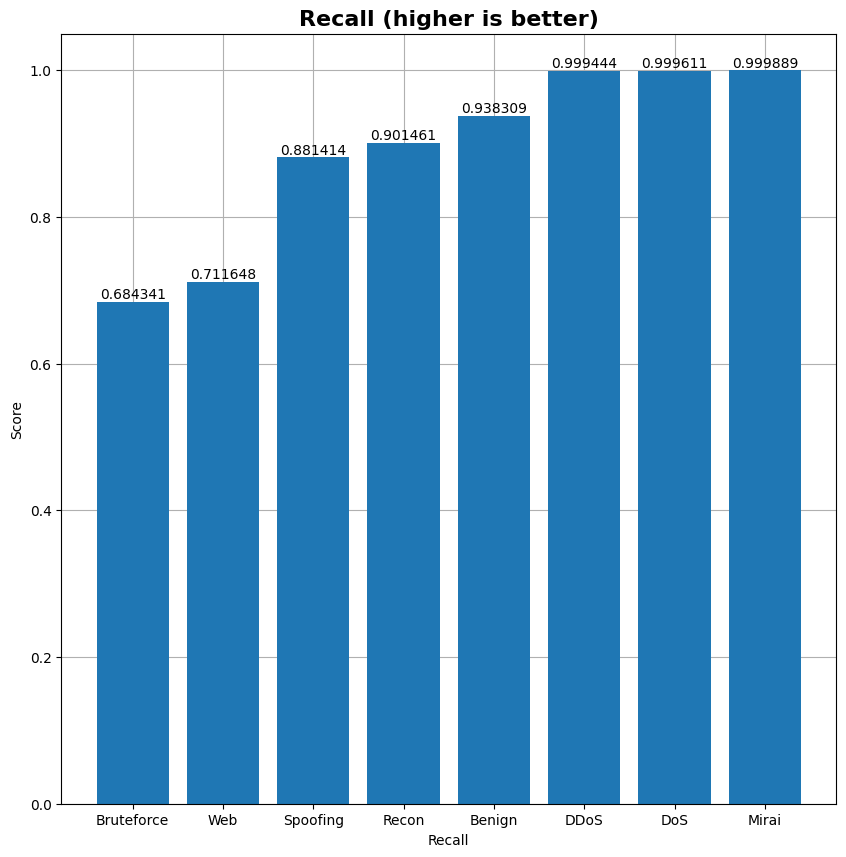

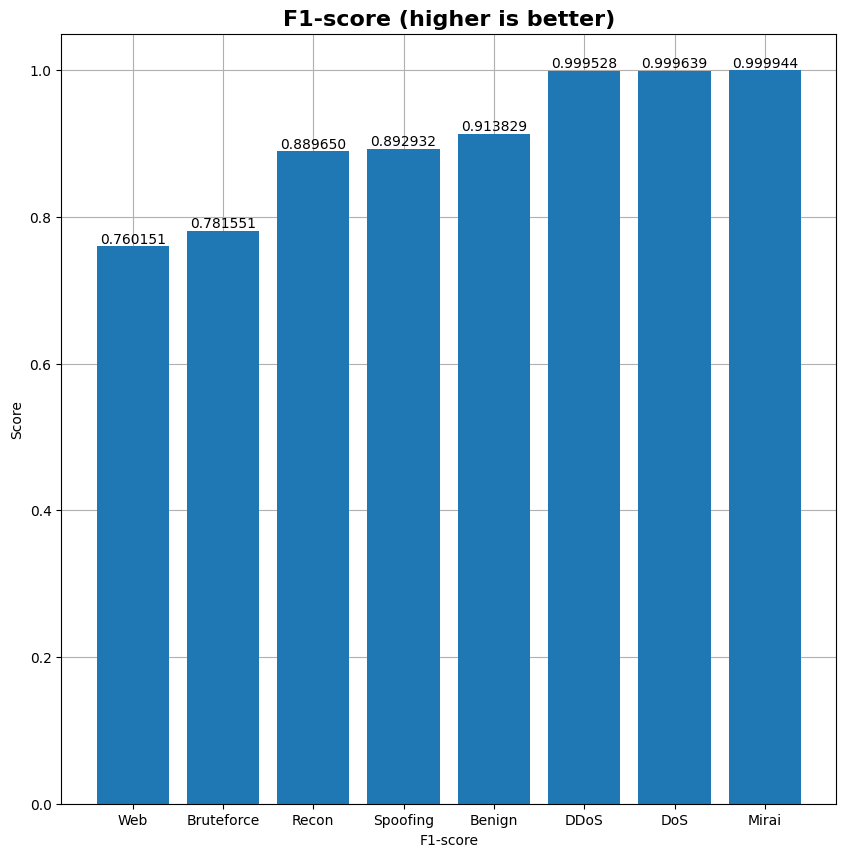

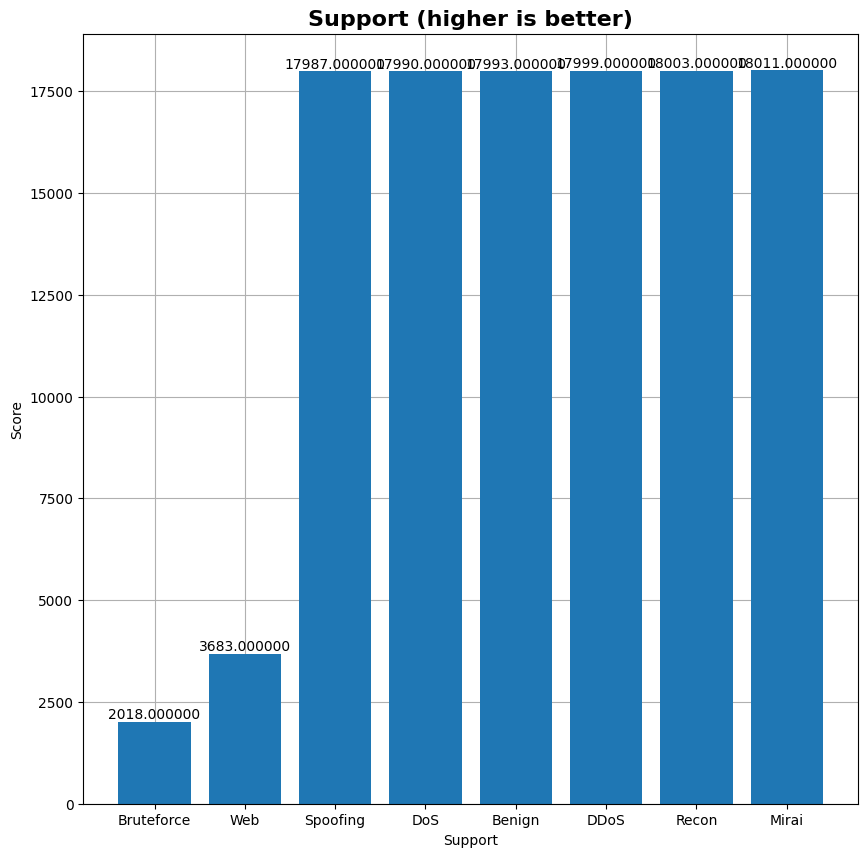

In [140]:
for name in mc_results:
    _dict = {}
    for keys, values in zip(range(len(mc_results[name].keys())), mc_results[name]):
        _dict[mc_results[name].keys()[keys]] = values
    result_plot(_dict, name, "multiclass_by_class")

# Load model

In [15]:
loaded_model = pickle.load(open('RF_1000.sav', 'rb'))
y_pred = loaded_model.predict(X_test)

In [16]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [18]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse]
results_dict["XGBoost_upd"] = results

In [20]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE"])

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE
XGBoost_upd,0.98,0.980233,0.979974,0.98,0.977169,0.055833,0.230833,0.480451
